In [1]:
whos

Interactive namespace is empty.


In [2]:
# imports, global settings

import numpy as np
import pandas as pd

import sklearn as sk
import sklearn.feature_extraction
import sklearn.preprocessing
import sklearn.linear_model

import IPython as IP

import matplotlib.pyplot as plt
%matplotlib inline

import pylab
# print (pylab.rcParams.keys())
pylab.rcParams['figure.figsize'] = (18.0, 8.0)
pylab.rcParams['figure.facecolor'] = "white"
pylab.rcParams['axes.facecolor'] = "white"
pylab.rcParams['font.family'] = "sans"

import matplotlib
matplotlib.style.use('ggplot') # temporary for incompatibility of pandas with matplotlib
# pd.options.display.mpl_style = 'default'
from statsmodels import graphics

pd.set_option('display.max_rows', 10)

In [3]:
# loading cohorts: number of users (new_users_total) and cohort IDs (id)

cohorts = pd.read_csv('Data/new_users.csv', parse_dates=[0], dayfirst=True, infer_datetime_format=True)
cohorts['new_users_total'] = cohorts['new_users_organic'] + cohorts['new_users_referred']
cohorts['id'] = cohorts['period'].dt.to_period(freq='M').astype('str')
cohorts.set_index('id', inplace=True)

In [4]:
cohorts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61 entries, 2012-12 to 2017-12
Data columns (total 4 columns):
period                61 non-null datetime64[ns]
new_users_organic     61 non-null int64
new_users_referred    61 non-null int64
new_users_total       61 non-null int64
dtypes: datetime64[ns](1), int64(3)
memory usage: 2.4+ KB


In [5]:
cohorts

,period,new_users_organic,new_users_referred,new_users_total
id,,,,
2012-12,2012-12-01,74,6,80
2013-01,2013-01-01,26,0,26
2013-02,2013-02-01,128,7,135
2013-03,2013-03-01,294,24,318
2013-04,2013-04-01,345,47,392
...,...,...,...,...
2017-08,2017-08-01,1000,4313,5313
2017-09,2017-09-01,1000,4171,5171
2017-10,2017-10-01,1000,3860,4860


In [6]:
# loading orders, filling in dates of user activation if not present

orders = pd.read_csv('Data/orders.csv', index_col='id', 
                     parse_dates=[2, 3, 6, 7], dayfirst=True, infer_datetime_format=True)
orders.columns=['user_id', 'date', 'date_end', 'status', 'amount', 'user_date_joined', 'user_date_activated']
orders['user_date_activated'].fillna(value=orders['user_date_joined'], inplace=True)

In [7]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15377 entries, 11 to 15873
Data columns (total 7 columns):
user_id                15377 non-null int64
date                   15377 non-null datetime64[ns]
date_end               14747 non-null datetime64[ns]
status                 15377 non-null int64
amount                 15377 non-null int64
user_date_joined       15377 non-null datetime64[ns]
user_date_activated    15377 non-null datetime64[ns]
dtypes: datetime64[ns](4), int64(3)
memory usage: 961.1 KB


In [8]:
# appending fake orders so that every cohort has at least one (small) order every month - to fight numerical problems later

start_date = min(orders['date_end'].min(), cohorts['period'].min())
end_date = max(orders['date_end'].max(), cohorts['period'].max()) + pd.Timedelta(weeks=5)
date_range = pd.date_range(start=start_date, end=end_date, freq='M')
to_append = list()
for cohort_m in date_range:
    for order_m in date_range:
        if order_m >= cohort_m:
            to_append.append({'user_id': -1, 
                              'date_end': pd.to_datetime(order_m), 
                              'status': 3, 
                              'amount': 1, 
                              'user_date_activated': pd.to_datetime(cohort_m)})
orders=orders.append(to_append, ignore_index=True)
to_append

[{'amount': 1,
  'date_end': Timestamp('2012-12-31 00:00:00', offset='M'),
  'status': 3,
  'user_date_activated': Timestamp('2012-12-31 00:00:00', offset='M'),
  'user_id': -1},
 {'amount': 1,
  'date_end': Timestamp('2013-01-31 00:00:00', offset='M'),
  'status': 3,
  'user_date_activated': Timestamp('2012-12-31 00:00:00', offset='M'),
  'user_id': -1},
 {'amount': 1,
  'date_end': Timestamp('2013-02-28 00:00:00', offset='M'),
  'status': 3,
  'user_date_activated': Timestamp('2012-12-31 00:00:00', offset='M'),
  'user_id': -1},
 {'amount': 1,
  'date_end': Timestamp('2013-03-31 00:00:00', offset='M'),
  'status': 3,
  'user_date_activated': Timestamp('2012-12-31 00:00:00', offset='M'),
  'user_id': -1},
 {'amount': 1,
  'date_end': Timestamp('2013-04-30 00:00:00', offset='M'),
  'status': 3,
  'user_date_activated': Timestamp('2012-12-31 00:00:00', offset='M'),
  'user_id': -1},
 {'amount': 1,
  'date_end': Timestamp('2013-05-31 00:00:00', offset='M'),
  'status': 3,
  'user_date_ac

In [9]:
# calculating features/predictors for the model:
## cohort ID for the order (cohort_id)
## months from the cohort start (cohort_m)
## order month (order_m)
## order year and quarter (order_yq)

orders['cohort_id'] = orders['user_date_activated'].dt.to_period(freq='M').astype('str')
orders['cohort_m'] = (orders['date_end'].dt.year - orders['user_date_activated'].dt.year) * 12 + \
    orders['date_end'].dt.month - orders['user_date_activated'].dt.month
orders['order_m'] = orders['date_end'].dt.month
orders['order_yq'] = orders['date_end'].dt.to_period(freq='Q').astype('str')
orders['n'] = 1
# orders['date_d'] = orders['date_end'].values.astype('<M8[D]')
orders

,user_id,date,date_end,status,amount,user_date_joined,user_date_activated,cohort_id,cohort_m,order_m,order_yq,n
0,33,2012-12-11 10:21:00,2012-12-11 10:21:00,3,4600,2012-12-11 10:16:00,2012-12-11 10:16:00,2012-12,0.0,12.0,2012Q4,1
1,38,2012-12-11 13:44:00,2012-12-11 13:44:00,3,8800,2012-12-11 13:39:00,2012-12-11 13:39:00,2012-12,0.0,12.0,2012Q4,1
2,42,2012-12-11 17:43:00,2012-12-11 17:43:00,3,4600,2012-12-11 17:40:00,2012-12-11 17:40:00,2012-12,0.0,12.0,2012Q4,1
3,26,2012-12-11 23:14:00,2012-12-11 23:14:00,3,8800,2012-12-10 15:23:00,2012-12-10 15:23:00,2012-12,0.0,12.0,2012Q4,1
4,75,2012-12-15 18:25:00,2012-12-15 18:25:00,3,17000,2012-12-15 16:55:00,2012-12-15 16:55:00,2012-12,0.0,12.0,2012Q4,1
...,...,...,...,...,...,...,...,...,...,...,...,...
17263,-1,NaT,2017-11-30 00:00:00,3,1,NaT,2017-10-31 00:00:00,2017-10,1.0,11.0,2017Q4,1
17264,-1,NaT,2017-12-31 00:00:00,3,1,NaT,2017-10-31 00:00:00,2017-10,2.0,12.0,2017Q4,1
17265,-1,NaT,2017-11-30 00:00:00,3,1,NaT,2017-11-30 00:00:00,2017-11,0.0,11.0,2017Q4,1
17266,-1,NaT,2017-12-31 00:00:00,3,1,NaT,2017-11-30 00:00:00,2017-11,1.0,12.0,2017Q4,1


In [10]:
# filtering (only delivered orders before 2015.12), and summing up order volume (amount) and quantity (n)

dataset = (
    orders
    .query('status == 3 and date_end < "2015-12"')
    .groupby(['cohort_id', 'cohort_m', 'order_m', 'order_yq'])
    ['amount', 'n']
    .sum()
    .reset_index()
)
dataset

,cohort_id,cohort_m,order_m,order_yq,amount,n
0,2012-12,0.0,12.0,2012Q4,106501,18
1,2012-12,1.0,1.0,2013Q1,22001,3
2,2012-12,2.0,2.0,2013Q1,35399,7
3,2012-12,3.0,3.0,2013Q1,75588,11
4,2012-12,4.0,4.0,2013Q2,26201,4
...,...,...,...,...,...,...
661,2015-09,1.0,10.0,2015Q4,605501,102
662,2015-09,2.0,11.0,2015Q4,364001,55
663,2015-10,0.0,10.0,2015Q4,877501,148
664,2015-10,1.0,11.0,2015Q4,530501,74


In [11]:
# joining orders with cohorts to get the number of users (new_users_total) in cohorts
# calculating amounts (amount_u) and quantities (n_u) of orders per cohort user
# also getting split between organic (new_users_organic) and referral growth (new_users_referred) as predictors

dataset[['new_users_total', 'new_users_organic', 'new_users_referred']] = (dataset.
                                                                       join(cohorts, on='cohort_id')
                                                                       [['new_users_total', 
                                                                         'new_users_organic', 
                                                                         'new_users_referred']]
                                                                       )
dataset.eval('''
    amount_u = amount / new_users_total
    n_u = n / new_users_total
''', inplace=True)
dataset

,cohort_id,cohort_m,order_m,order_yq,amount,n,new_users_total,new_users_organic,new_users_referred,amount_u,n_u
0,2012-12,0.0,12.0,2012Q4,106501,18,80,74,6,1331.262500,0.225000
1,2012-12,1.0,1.0,2013Q1,22001,3,80,74,6,275.012500,0.037500
2,2012-12,2.0,2.0,2013Q1,35399,7,80,74,6,442.487500,0.087500
3,2012-12,3.0,3.0,2013Q1,75588,11,80,74,6,944.850000,0.137500
4,2012-12,4.0,4.0,2013Q2,26201,4,80,74,6,327.512500,0.050000
...,...,...,...,...,...,...,...,...,...,...,...
661,2015-09,1.0,10.0,2015Q4,605501,102,1989,1000,989,304.424837,0.051282
662,2015-09,2.0,11.0,2015Q4,364001,55,1989,1000,989,183.007039,0.027652
663,2015-10,0.0,10.0,2015Q4,877501,148,1884,1000,884,465.764862,0.078556
664,2015-10,1.0,11.0,2015Q4,530501,74,1884,1000,884,281.582272,0.039278


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f04c8fa40f0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f04c9049940>]], dtype=object)

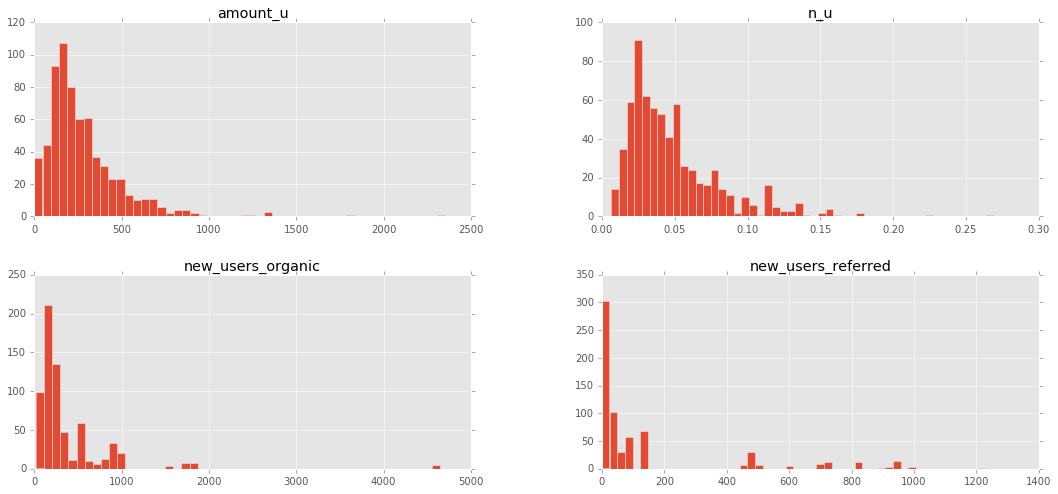

In [12]:
# histograms show that the distributions are far from normal
# but let's try to take a log and pray...

# TODO: actually, this should be negative-binomial (gamma-poisson) distribution, need to do a proper negative-binomial regression

dataset[['n_u', 'amount_u', 'new_users_organic', 'new_users_referred']].hist(bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f04c80fd358>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f04a979ef60>]], dtype=object)

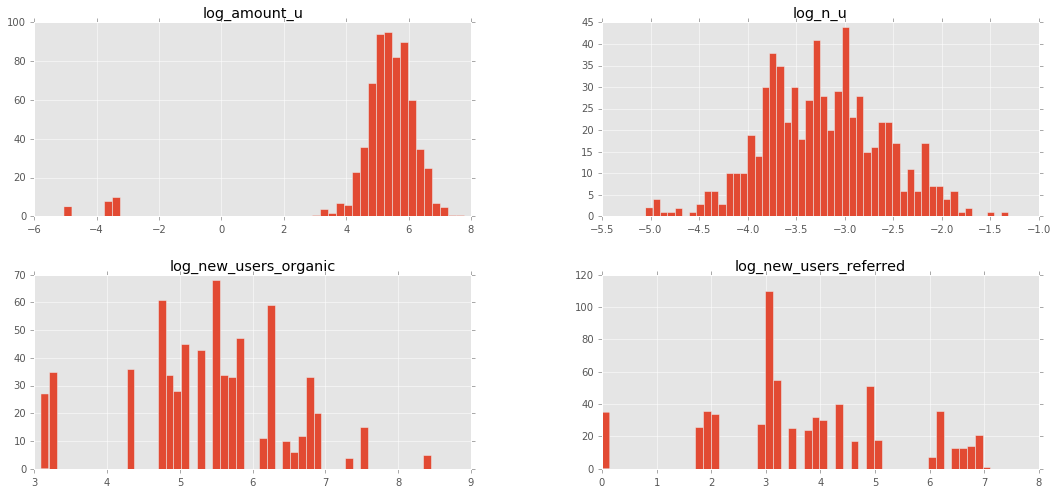

In [13]:
# ... it is looking much better now, but it's clear that there are outliers in monetary amounts
# (remember, we actually inserted some of them earlier to have some information for every cohort, but it's not only those)

# we can trim them and ignore these periods, but we'll lose infomation that there was zero orders then
# so, let's predict only order log-quantities (log_n_u) - they look much more robust

# also calculating log-quantities of users in cohorts (log_new_users_organic and log_new_users_referred) as predictors

dataset.eval('''
    log_new_users_organic = log(new_users_organic + 1)     # +1 - to get around possible zeros
    log_new_users_referred = log(new_users_referred + 1)
    log_amount_u = log(amount_u)
    log_n_u = log(n_u)                                     # +1 not needed here because we inserted fake orders
''', inplace=True)
dataset[['log_n_u', 'log_amount_u', 'log_new_users_organic', 'log_new_users_referred']].hist(bins=50)

In [14]:
# our predicted values

y = dataset['log_n_u']
y

0     -1.491655
1     -3.283414
2     -2.436116
3     -1.984131
4     -2.995732
         ...   
661   -2.970414
662   -3.588054
663   -2.543940
664   -3.237087
665   -2.717978
Name: log_n_u, dtype: float64

In [15]:
# transforming our predictors into feature vectors
## one-hot encoding for cohort_id and order_yq
## one-hot encoding for cohort_m with cohort_m >= 12 in one category (to minimize the number of free parameters)
## one-hot encoding for order_m
## log_cohort_users as is

X = pd.DataFrame()

dv = sk.feature_extraction.DictVectorizer(sparse=False)
X_m = dv.fit_transform(dataset[['cohort_id', 'order_yq']].to_dict(orient='records'))
X_names = dv.feature_names_
X_df = pd.DataFrame(data=X_m, columns=X_names)
print(X_df.shape)
X = pd.concat([X, X_df], axis=1, copy=False)
print(X.shape)

oh = sk.preprocessing.OneHotEncoder(sparse=False)
# X_m = oh.fit_transform(dataset[['cohort_m']])
X_m = oh.fit_transform(np.asmatrix([min(m, 11) for m in dataset['cohort_m'].values]).T)
X_names = ['cohort_m=' + str(m) for m in oh.active_features_]
X_df = pd.DataFrame(data=X_m, columns=X_names)
print(X_df.shape)
X = pd.concat([X, X_df], axis=1, copy=False)
print(X.shape)

oh = sk.preprocessing.OneHotEncoder(sparse=False)
X_m = oh.fit_transform(dataset[['order_m']])
X_names = ['order_m=' + str(m) for m in oh.active_features_]
X_df = pd.DataFrame(data=X_m, columns=X_names)
print(X_df.shape)
X = pd.concat([X, X_df], axis=1, copy=False)
print(X.shape)

X[['log_new_users_organic', 'log_new_users_referred']] = dataset[['log_new_users_organic', 'log_new_users_referred']]
print(X.shape)

(666, 49)
(666, 49)
(666, 12)
(666, 61)
(666, 12)
(666, 73)
(666, 75)


In [16]:
# our feature vectors

pd.set_option('expand_frame_repr', False)
pd.set_option('max_colwidth', 40)
pd.set_option('display.max_columns', 100)

IP.display.display(X)

pd.reset_option('expand_frame_repr')
pd.reset_option('max_colwidth')
pd.reset_option('display.max_columns')

,cohort_id=2012-12,cohort_id=2013-01,cohort_id=2013-02,cohort_id=2013-03,cohort_id=2013-04,cohort_id=2013-05,cohort_id=2013-06,cohort_id=2013-07,cohort_id=2013-08,cohort_id=2013-09,cohort_id=2013-10,cohort_id=2013-11,cohort_id=2013-12,cohort_id=2014-01,cohort_id=2014-02,cohort_id=2014-03,cohort_id=2014-04,cohort_id=2014-05,cohort_id=2014-06,cohort_id=2014-07,cohort_id=2014-08,cohort_id=2014-09,cohort_id=2014-10,cohort_id=2014-11,cohort_id=2014-12,cohort_id=2015-01,cohort_id=2015-02,cohort_id=2015-03,cohort_id=2015-04,cohort_id=2015-05,cohort_id=2015-06,cohort_id=2015-07,cohort_id=2015-08,cohort_id=2015-09,cohort_id=2015-10,cohort_id=2015-11,order_yq=2012Q4,order_yq=2013Q1,order_yq=2013Q2,order_yq=2013Q3,order_yq=2013Q4,order_yq=2014Q1,order_yq=2014Q2,order_yq=2014Q3,order_yq=2014Q4,order_yq=2015Q1,order_yq=2015Q2,order_yq=2015Q3,order_yq=2015Q4,cohort_m=0,cohort_m=1,cohort_m=2,cohort_m=3,cohort_m=4,cohort_m=5,cohort_m=6,cohort_m=7,cohort_m=8,cohort_m=9,cohort_m=10,cohort_m=11,order_m=1,order_m=2,order_m=3,order_m=4,order_m=5,order_m=6,order_m=7,order_m=8,order_m=9,order_m=10,order_m=11,order_m=12,log_new_users_organic,log_new_users_referred
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.317488,1.945910
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.317488,1.945910
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.317488,1.945910
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.317488,1.945910
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.317488,1.945910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
661,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6.908755,6.897705
662,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,6.908755,6.897705
663,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6.908755,6.785588
664,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [17]:
# training the model
## ARDRegression is chosen because it provides estimates for parameter variance and we want to see confidence intervals
## we also want to heavily regularise the model because the amount of data is low
## just to check, lasso gives very similar results

lm = sk.linear_model.ARDRegression(compute_score=True, threshold_lambda=1e+6)
# lm = sk.linear_model.LassoCV(eps=0.0001, n_alphas=1000, max_iter=10000, cv=5, n_jobs=-1, 
#                              random_state=0, selection='random')
lm.fit(X, y)
print(lm.score(X, y))

0.647718780671


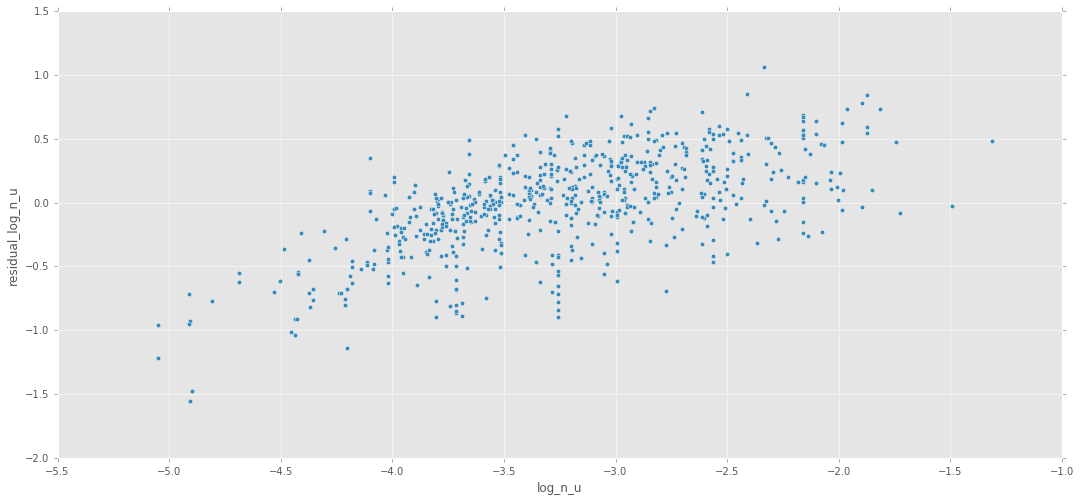

In [18]:
# checking residuals, looking normal

dataset['residual_log_n_u'] = (y - lm.predict(X))
dataset.plot.scatter(x='log_n_u', y='residual_log_n_u')

In [19]:
# getting parameter means

theta = pd.DataFrame(index=X.columns)
theta['mean'] = lm.coef_
theta.loc['intercept', 'mean'] = lm.intercept_

In [20]:
# getting parameter precision (higher - worse) and 2 std devs

# TODO: this is a naive way to estimate variances, since we have correlations between parameters
# need to sample from covariance matrix

theta['precision'] = list(lm.lambda_) + [0]
theta['2 sigma'] = list(2 * np.diag(lm.sigma_) ** 0.5) + [0]

In [21]:
# our parameters
## we see here that the bigger organic growth the less marginal value it brings, but it's not the same for referral!

pd.set_option('display.max_rows', 100)

IP.display.display(theta)

pd.set_option('display.max_rows', 10)

,mean,precision,2 sigma
cohort_id=2012-12,0.575529,2.974593,0.140641
cohort_id=2013-01,0.523748,3.560882,0.161434
cohort_id=2013-02,-0.158144,34.250849,0.129379
cohort_id=2013-03,-0.000293,9736.341051,0.020031
cohort_id=2013-04,0.009007,1446.472345,0.049517
cohort_id=2013-05,-0.000359,9273.595273,0.020606
cohort_id=2013-06,0.000247,10243.046488,0.021607
cohort_id=2013-07,-0.452883,4.744491,0.150541
cohort_id=2013-08,-0.260118,13.708399,0.145391
cohort_id=2013-09,-0.001009,5426.156002,0.026919


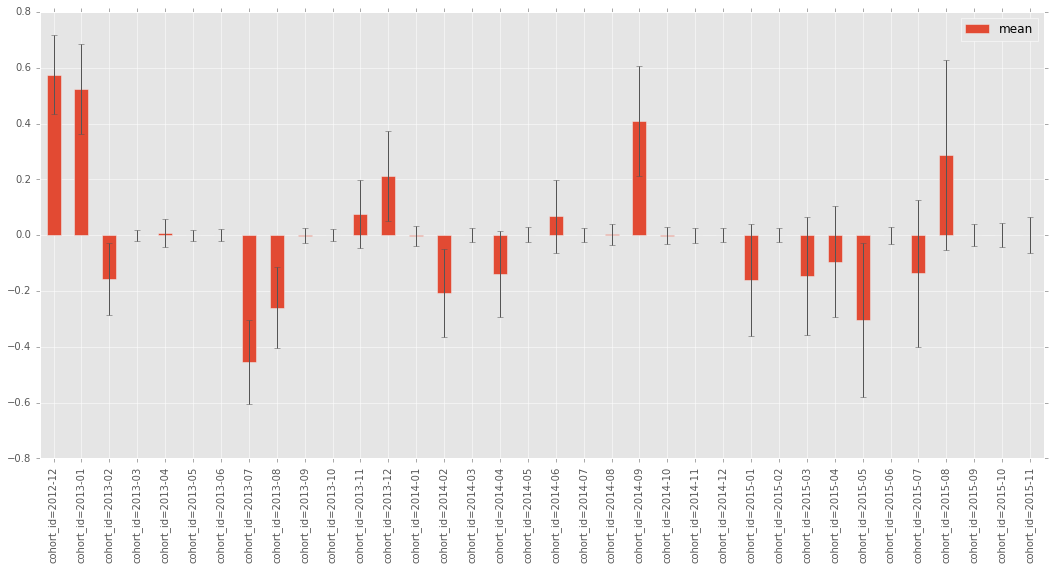

In [22]:
# cohort strengths

theta.loc[theta.index.str.startswith('cohort_id')][['mean', '2 sigma']].plot.bar(yerr='2 sigma')
# theta.loc[theta.index.str.startswith('cohort_id')][['mean']].plot.bar()

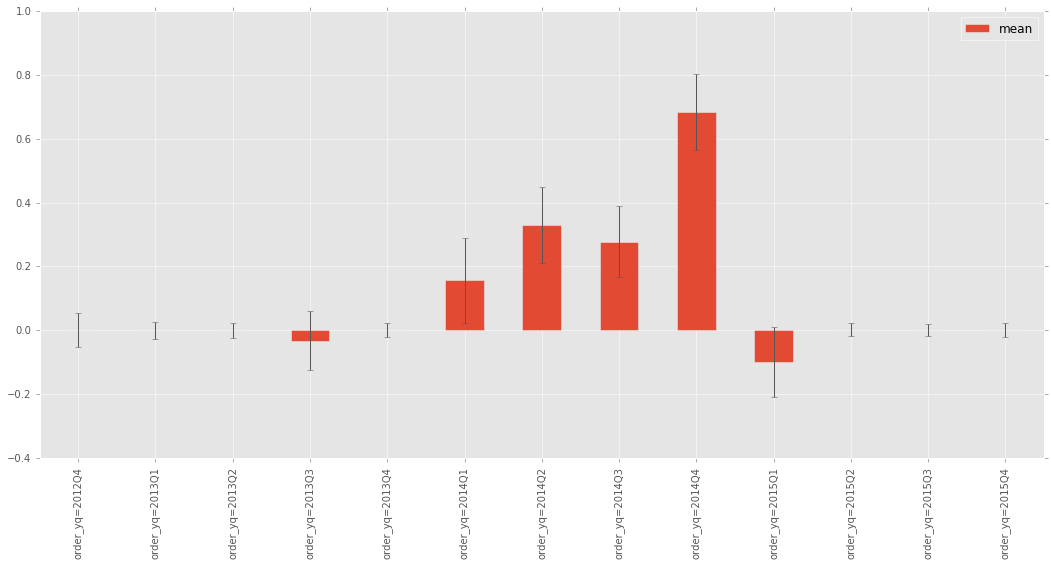

In [23]:
# quaterly trend: 2014 was a golden age, especially the fourth quarter

theta.loc[theta.index.str.startswith('order_yq')][['mean', '2 sigma']].plot.bar(yerr='2 sigma')
# theta.loc[theta.index.str.startswith('order_yq')][['mean']].plot.bar()

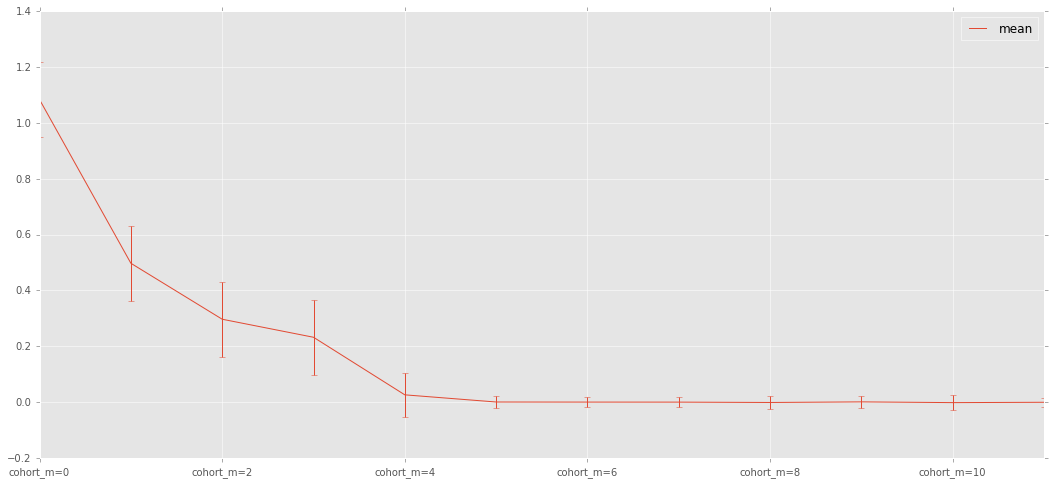

In [24]:
# cohort shape

theta.loc[theta.index.str.startswith('cohort_m')][['mean', '2 sigma']].plot(yerr='2 sigma')
# theta.loc[theta.index.str.startswith('cohort_m')][['mean']].plot()

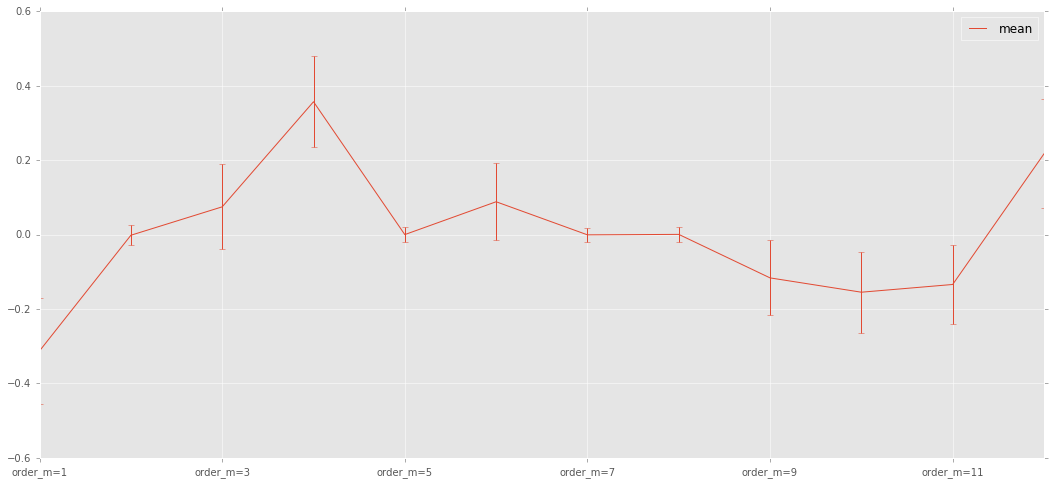

In [25]:
# seasonality by months: surprisingly, the strongest month doesn't seem to be December, but April!
## but it's been only three years, so the intervals here are rather wide

theta.loc[theta.index.str.startswith('order_m')][['mean', '2 sigma']].plot(yerr='2 sigma')
# theta.loc[theta.index.str.startswith('order_m')][['mean']].plot()